In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.ops import unary_union
from shapely.geometry import Point, Polygon
from geopy import geocoders 
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
from translitua import translit

# Preprocess regions

In [2]:
regions_path = "data/regions/UKR_adm1.shp"

In [3]:
df_regions = gpd.read_file(regions_path)
df_regions.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,HASC_1,CCN_1,CCA_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,240,UKR,Ukraine,1,Cherkasy,UA.CK,0,None,Oblast',Region,None,Cherkas'ka Oblast'|Cherkasskaya Oblast'|Cherkassy,"POLYGON ((32.15047 50.19769, 32.15050 50.19181..."
1,240,UKR,Ukraine,2,Chernihiv,UA.CH,0,None,Oblast',Region,None,Chernigov|Tschernigow,"POLYGON ((33.19667 52.37500, 33.20612 52.36700..."
2,240,UKR,Ukraine,3,Chernivtsi,UA.CV,0,None,Oblast',Region,None,Chernivets'ka Oblast'|Chernovitskaya Oblast'|C...,"POLYGON ((25.62595 48.67673, 25.64460 48.67159..."
3,240,UKR,Ukraine,4,Crimea,UA.KR,0,None,Autonomous Republic,Autonomous Republic,None,CrimÃ©e|CrimÃ©ia|Krim|Krymskaya Respublika|Res...,"MULTIPOLYGON (((33.79458 44.39153, 33.79291 44..."
4,240,UKR,Ukraine,5,Dnipro,UA.DP,0,None,Oblast',Region,None,Dnipropetrovsk|Dniepropietrovsk|Dnjepropetrowsk,"POLYGON ((34.92995 49.15574, 34.92076 49.14992..."


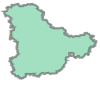

In [4]:
# there is a separate polygon shape fot Kiev city, excluded from its region
# merge them into one region and remove the city
merged_kyiv = unary_union(df_regions[df_regions['NAME_1'].isin(['Kyiv', 'Kyiv City'])]['geometry'])
df_regions = df_regions.drop(df_regions[df_regions['NAME_1'] == 'Kyiv City'].index)
df_regions.loc[df_regions['NAME_1'] == 'Kyiv', 'geometry'] = merged_kyiv

merged_kyiv

In [5]:
df_regions.to_csv("data/preprocessed/regions.csv", index=False)

# Preprocess cities

In [6]:
df = pd.read_csv("data/cities/cities.csv")[["name", "location", "population"]]
df.head()

,name,location,population
0,Urzuf,"{""__type"":""GeoPoint"",""latitude"":46.91562,""long...",2904
1,Zuhres,"{""__type"":""GeoPoint"",""latitude"":48.0114,""longi...",19121
2,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",22608
3,Zhydachiv,"{""__type"":""GeoPoint"",""latitude"":49.38468,""long...",0
4,Kovyl’noye,"{""__type"":""GeoPoint"",""latitude"":45.69028,""long...",783


In [7]:
def get_latitude(x):
    x_json = json.loads(x)
    return x_json["latitude"]

def get_longitude(x):
    x_json = json.loads(x)
    return x_json["longitude"]

In [8]:
df["latitude"] = df["location"].apply(get_latitude)
df["longitude"] = df["location"].apply(get_longitude)
df.head()

,name,location,population,latitude,longitude
0,Urzuf,"{""__type"":""GeoPoint"",""latitude"":46.91562,""long...",2904,46.91562,37.09961
1,Zuhres,"{""__type"":""GeoPoint"",""latitude"":48.0114,""longi...",19121,48.01140,38.26444
2,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",22608,49.80597,24.89436
3,Zhydachiv,"{""__type"":""GeoPoint"",""latitude"":49.38468,""long...",0,49.38468,24.14254
4,Kovyl’noye,"{""__type"":""GeoPoint"",""latitude"":45.69028,""long...",783,45.69028,33.52775


In [9]:
def get_region(row):
    coord = f"{row['latitude']}, {row['longitude']}"
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    region = address.get('state', '')
    row["region"] = region
    return row

In [10]:
df = df.apply(get_region, axis=1)

In [11]:
df.replace("Республика Крым", "Республіка Крим", inplace=True)

In [12]:
df[df["region"] == '']

,name,location,population,latitude,longitude,region
41,Zavetnoye,"{""__type"":""GeoPoint"",""latitude"":45.32697,""long...",1628,45.32697,34.80837,
489,Pyatikhatka,"{""__type"":""GeoPoint"",""latitude"":45.32347,""long...",2375,45.32347,34.25516,
850,Livadia,"{""__type"":""GeoPoint"",""latitude"":44.47021,""long...",1074,44.47021,34.14272,
874,Kyiv,"{""__type"":""GeoPoint"",""latitude"":50.45466,""long...",2797553,50.45466,30.52380,
1384,Bakhchisaray,"{""__type"":""GeoPoint"",""latitude"":44.75525,""long...",27351,44.75525,33.85782,
1492,Polyushko,"{""__type"":""GeoPoint"",""latitude"":44.74219,""long...",1951,44.74219,33.58913,


In [13]:
df.iloc[41, 3] = "Республіка Крим"
df.iloc[489, 3] = "Республіка Крим"
df.iloc[850, 3] = "Республіка Крим"
df.iloc[874, 3] = "Київська область"
df.iloc[1384, 3] = "Республіка Крим"
df.iloc[1492, 3] = "Республіка Крим"

In [14]:
df.replace('Донецька область', 'Donetska', inplace=True)
df.replace('Львівська область', 'Lvivska', inplace=True)
df.replace('Республіка Крим', 'Crimea', inplace=True)
df.replace('Черкаська область', 'Cherkaska', inplace=True)
df.replace('Запорізька область', 'Zaporizka', inplace=True)
df.replace('Луганська область', 'Luhanska', inplace=True)
df.replace('Сумська область', 'Sumska', inplace=True)
df.replace('Харківська область', 'Kharkivska', inplace=True)
df.replace('Тернопільська область', 'Ternopilska', inplace=True)
df.replace('Кіровоградська область', 'Kirovohradska', inplace=True)
df.replace('Хмельницька область', 'Khmelnytska', inplace=True)
df.replace('Житомирська область', 'Zhytomyrska', inplace=True)
df.replace('Київська область', 'Kyivska', inplace=True)
df.replace('Чернігівська область', 'Chernihivska', inplace=True)
df.replace('Волинська область', 'Volynska', inplace=True)
df.replace('Полтавська область', 'Poltavska', inplace=True)
df.replace('Вінницька область', 'Vinnytska', inplace=True)
df.replace('Дніпропетровська область', 'Dnipropetrovska', inplace=True)
df.replace('Івано-Франківська область', 'Ivano-Frankivska', inplace=True)
df.replace('Одеська область', 'Odeska', inplace=True)
df.replace('Рівненська область', 'Rivnenska', inplace=True)
df.replace('Чернівецька область', 'Chernivetska', inplace=True)
df.replace('Херсонська область', 'Khersonska', inplace=True)
df.replace('Закарпатська область', 'Zakarpatska', inplace=True)
df.replace('Миколаївська область', 'Mykolaivska', inplace=True)
df.replace('Севастополь', 'Crimea', inplace=True)


In [15]:
df.to_csv('data/preprocessed/cities.csv', index=False)

In [16]:
df = pd.read_csv('data/preprocessed/cities.csv')
df.head()

,name,location,population,latitude,longitude,region
0,Urzuf,"{""__type"":""GeoPoint"",""latitude"":46.91562,""long...",2904,46.91562,37.09961,Donetska
1,Zuhres,"{""__type"":""GeoPoint"",""latitude"":48.0114,""longi...",19121,48.0114,38.26444,Donetska
2,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",22608,49.80597,24.89436,Lvivska
3,Zhydachiv,"{""__type"":""GeoPoint"",""latitude"":49.38468,""long...",0,49.38468,24.14254,Lvivska
4,Kovyl’noye,"{""__type"":""GeoPoint"",""latitude"":45.69028,""long...",783,45.69028,33.52775,Crimea


In [17]:
points = [Point(d['longitude'], d['latitude']) for d in map(json.loads, df['location'].to_numpy())]

df_cities = GeoDataFrame(df, geometry=points, crs=df_regions.crs)
df_cities.head()

,name,location,population,latitude,longitude,region,geometry
0,Urzuf,"{""__type"":""GeoPoint"",""latitude"":46.91562,""long...",2904,46.91562,37.09961,Donetska,POINT (37.09961 46.91562)
1,Zuhres,"{""__type"":""GeoPoint"",""latitude"":48.0114,""longi...",19121,48.0114,38.26444,Donetska,POINT (38.26444 48.01140)
2,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",22608,49.80597,24.89436,Lvivska,POINT (24.89436 49.80597)
3,Zhydachiv,"{""__type"":""GeoPoint"",""latitude"":49.38468,""long...",0,49.38468,24.14254,Lvivska,POINT (24.14254 49.38468)
4,Kovyl’noye,"{""__type"":""GeoPoint"",""latitude"":45.69028,""long...",783,45.69028,33.52775,Crimea,POINT (33.52775 45.69028)


# Preprocess destinations

In [18]:
df_report = pd.read_csv("data/tarilka/report.csv")[["Населений пункт", "К-сть осіб", "Статус"]]
df_report.fillna(0, inplace=True)
transliterated = [translit(name) for name in df_report['Населений пункт'].to_numpy()]
df_report.insert(1, 'name', transliterated)
df_report.head()

,Населений пункт,name,К-сть осіб,Статус
0,Харків,Kharkiv,1.0,0
1,Харків,Kharkiv,3.0,відправлено
2,Київ,Kyiv,3.0,відправлено
3,Запоріжжя,Zaporizhzhia,1.0,відправлено
4,Костянтинівка Донецька обл,Kostiantynivka Donetska obl,3.0,відправлено


In [19]:
df_report

,Населений пункт,name,К-сть осіб,Статус
0,Харків,Kharkiv,1.0,0
1,Харків,Kharkiv,3.0,відправлено
2,Київ,Kyiv,3.0,відправлено
3,Запоріжжя,Zaporizhzhia,1.0,відправлено
4,Костянтинівка Донецька обл,Kostiantynivka Donetska obl,3.0,відправлено
...,...,...,...,...
765,Миколаїв,Mykolaiv,1.0,очікує відправки
766,Южне Одеська обл,Yuzhne Odeska obl,3.0,очікує відправки
767,Кременчук,Kremenchuk,2.0,очікує відправки
768,Кропивницький,Kropyvnytskyi,2.0,очікує відправки


In [20]:
# if there is region, but the city is not found,
# take its administrative center
obl_to_cities = {
    'Cherkaska': 'Cherkasy',     'Chernihivska': 'Chernihiv',      'Chernivetska': 'Chernivtsi',
    'Dnipropetrovska': 'Dnipro', 'Donetska': 'Donetsk',            'Ivano-Frankivska': 'Ivano-Frankivsk',
    'Kharkivska': 'Kharkiv',     'Khersonska': 'Kherson',          'Khmelnytska': 'Khmelnytskyi',
    'Kyivska': 'Kyiv',           'Kirovohradska': 'Kropyvnytskyi', 'Lvivska': 'Lviv',
    'Luhanska': 'Luhansk',       'Mykolaivska': 'Mykolayiv',       'Odeska': 'Odessa',
    'Poltavska': 'Poltava',      'Rivnenska': 'Rivne',             'Sumska': 'Sumy',
    'Ternopilska': 'Ternopil',   'Zakarpatska': 'Uzhgorod',        'Vinnytska': 'Vinnytsia',
    'Volynska': 'Lutsk',         'Zaporizka': 'Zaporizhia',        'Zhytomyrska': 'Zhytomyr',
}

destinations = df_report['name'].to_numpy()
capacity = df_report['К-сть осіб'].to_numpy()

found = 0
found_dict = {}


def has_record(city: str, capacity: int) -> bool:
    if not df[df['name'] == city].empty:
        if city in found_dict:
            found_dict[city] += capacity
        else:
            found_dict[city] = capacity
        return True

    if city in obl_to_cities:
        if city in found_dict:
            found_dict[obl_to_cities[city]] += capacity
        else:
            found_dict[obl_to_cities[city]] = capacity
        return True

    return False


for idx, city in enumerate(destinations):
    for sub_name in city.split(' '):
        if has_record(sub_name, int(capacity[idx])):
            found += 1
            continue

print(f'Cities found: {found}\nCities not found: {len(destinations) - found}')

Cities found: 707
Cities not found: 63


In [21]:
df_destinations = df[df['name'].isin(found_dict.keys())][['name', 'location', 'region']]
df_destinations['capacity'] = list(map(found_dict.get, df_destinations['name'].to_numpy()))
df_destinations.head()

,name,location,region,capacity
2,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":49.80597,""long...",Lvivska,4
5,Druzhkivka,"{""__type"":""GeoPoint"",""latitude"":48.63013,""long...",Donetska,25
11,Lebedyn,"{""__type"":""GeoPoint"",""latitude"":50.58518,""long...",Sumska,4
18,Zolochiv,"{""__type"":""GeoPoint"",""latitude"":50.27985,""long...",Kharkivska,4
25,Zhytomyr,"{""__type"":""GeoPoint"",""latitude"":50.26487,""long...",Zhytomyrska,6


In [22]:
df_destinations.to_csv("data/preprocessed/destinations.csv", index=False)